<a href="https://colab.research.google.com/github/oopsys6/Time-Series-Forecasting-for-Covid19/blob/main/Ch4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. 데이터 모델링

이번 장에서는 LSTM을 사용하여 앞으로의 대한민국 코로나19 확진자 수를 예측해보는 모델을 구축해보겠습니다.

4.1절과 4.2절에서는 대한민국 코로나19 누적 확진자 수 데이터를 불러온 후, 데이터를 탐색하고 훈련용, 시험용 데이터로 나누어 보겠습니다. 4.3절에서는 LSTM 모델을 정의하고 4.4절에서는 정의한 모델을 사용하여 학습시켜 보겠습니다. 마지막으로 앞으로의 코로나 19 확진자 수에 대한 예측값을 확인해보겠습니다.





In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4.1 데이터 다운로드


모델링 실습을 위해 대한민국 코로나 누적 확진자 
데이터를 불러오겠습니다,

In [ ]:
!gdown --id 1DWkNk9ZKlzqvXFRrlF10mRc2lDn6reA4

Downloading...
From: https://drive.google.com/uc?id=1DWkNk9ZKlzqvXFRrlF10mRc2lDn6reA4
To: /content/korea_South_19-covid-Confirmed.csv
100% 4.49k/4.49k [00:00<00:00, 4.15MB/s]


## 4.2 데이터 탐색

데이터는 2020년 1월 22일부터 2020년 12월 14일까지의 누적된 확진자 수를 보여주고 있습니다.

In [ ]:
df = pd.read_csv('korea_South_19-covid-Confirmed.csv')
df.head()

,Country/Region,Province/State,Long,Lat,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20
0,"Korea, South",NaN,128,36,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,...,27195,27284,27427,27553,27653,27799,27942,28133,28338,28546,28767,28975,29197,29427,29740,30083,30403,30733,31004,31353,31735,32318,32887,33375,33824,34201,34652,35163,35702,36325,36908,37539,38154,38746,39417,40097,40786,41736,42766,43484


확진자 데이터만 추출 위해서 인덱싱을 진행합니다.



In [ ]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20
0,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,...,27195,27284,27427,27553,27653,27799,27942,28133,28338,28546,28767,28975,29197,29427,29740,30083,30403,30733,31004,31353,31735,32318,32887,33375,33824,34201,34652,35163,35702,36325,36908,37539,38154,38746,39417,40097,40786,41736,42766,43484


Series 타입이 데이터를 다루기 비교적 쉽기 때문에 `to_datetime`을 사용하여 df 타입을 Series 타입으로 바꿔 반환해줍니다.

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22    1
2020-01-23    1
2020-01-24    2
2020-01-25    2
2020-01-26    3
dtype: int64

학습을 위해 사용할 한국 코로나 확진자 누적 데이터를 시각화하여 볼 수 있습니다.

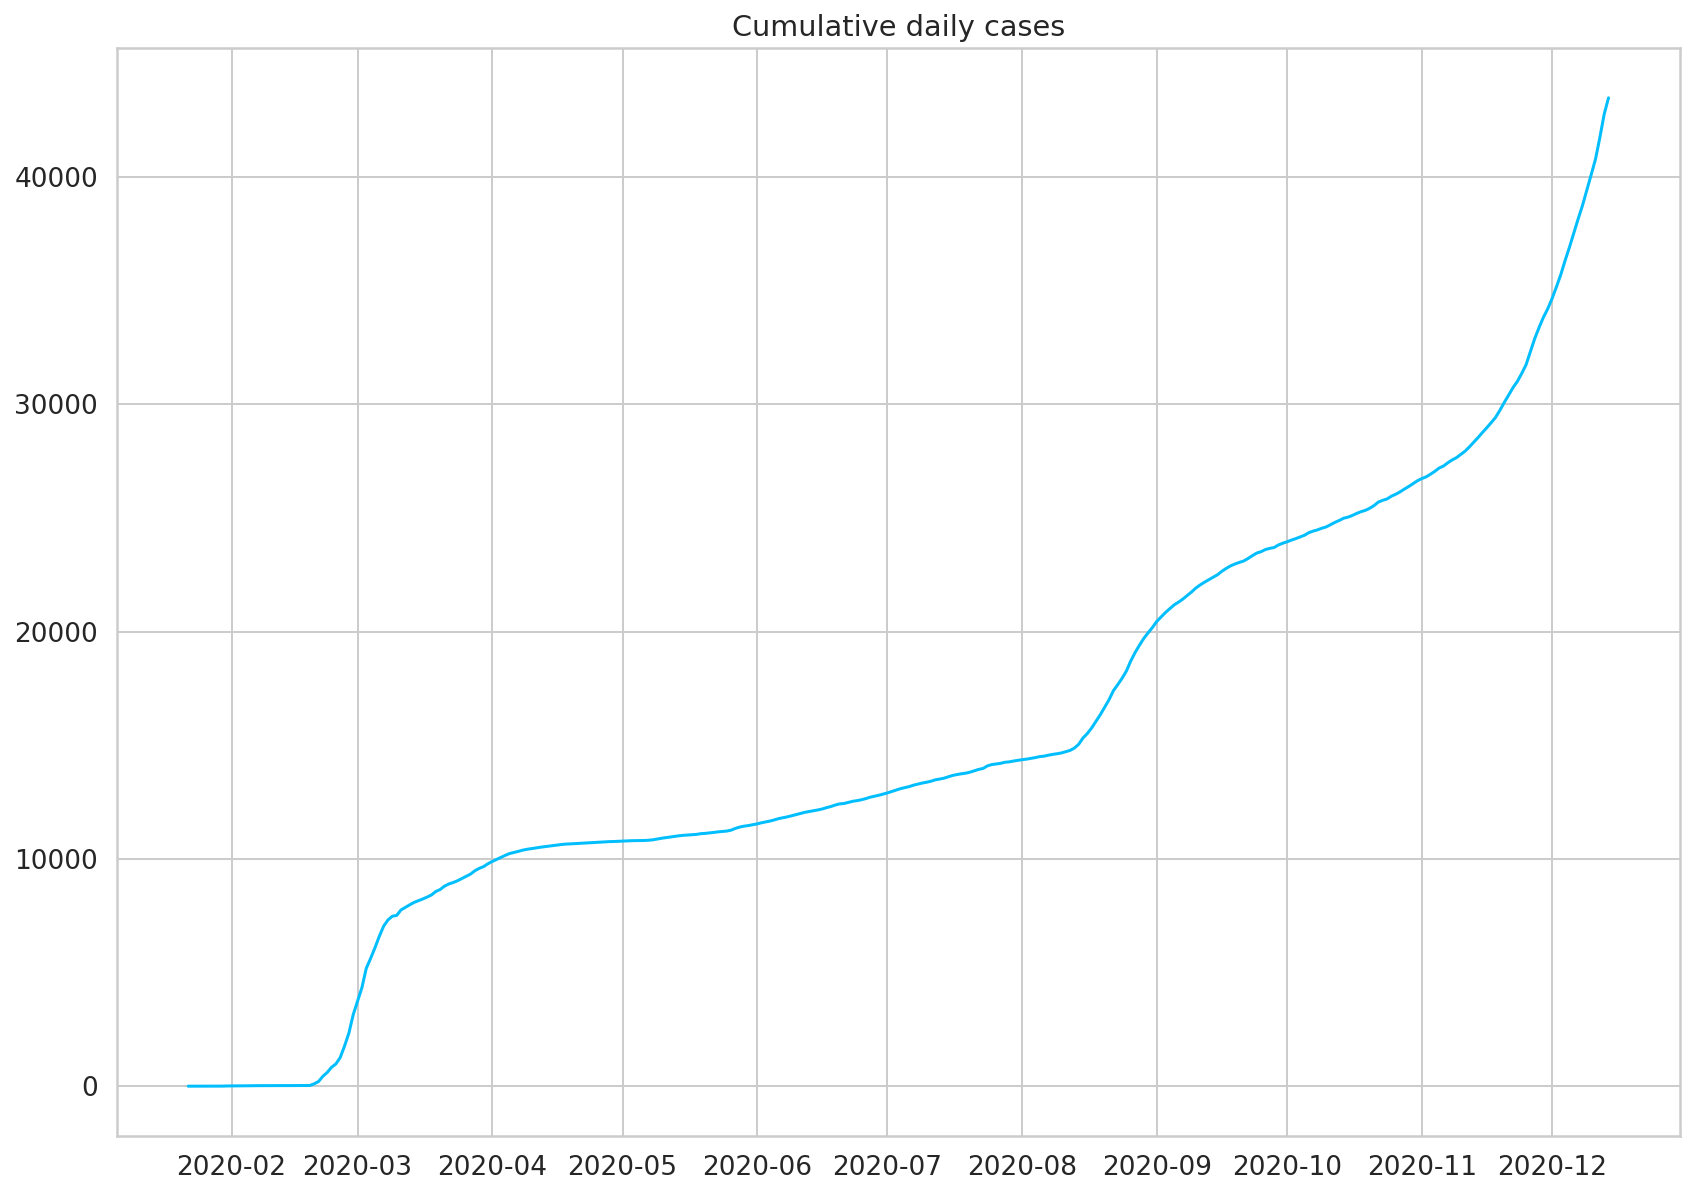

In [ ]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

다음은 확진자를 일일 단위로 확인하고 시각화 해보겠습니다.


In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    1
2020-01-23    0
2020-01-24    1
2020-01-25    0
2020-01-26    1
dtype: int64

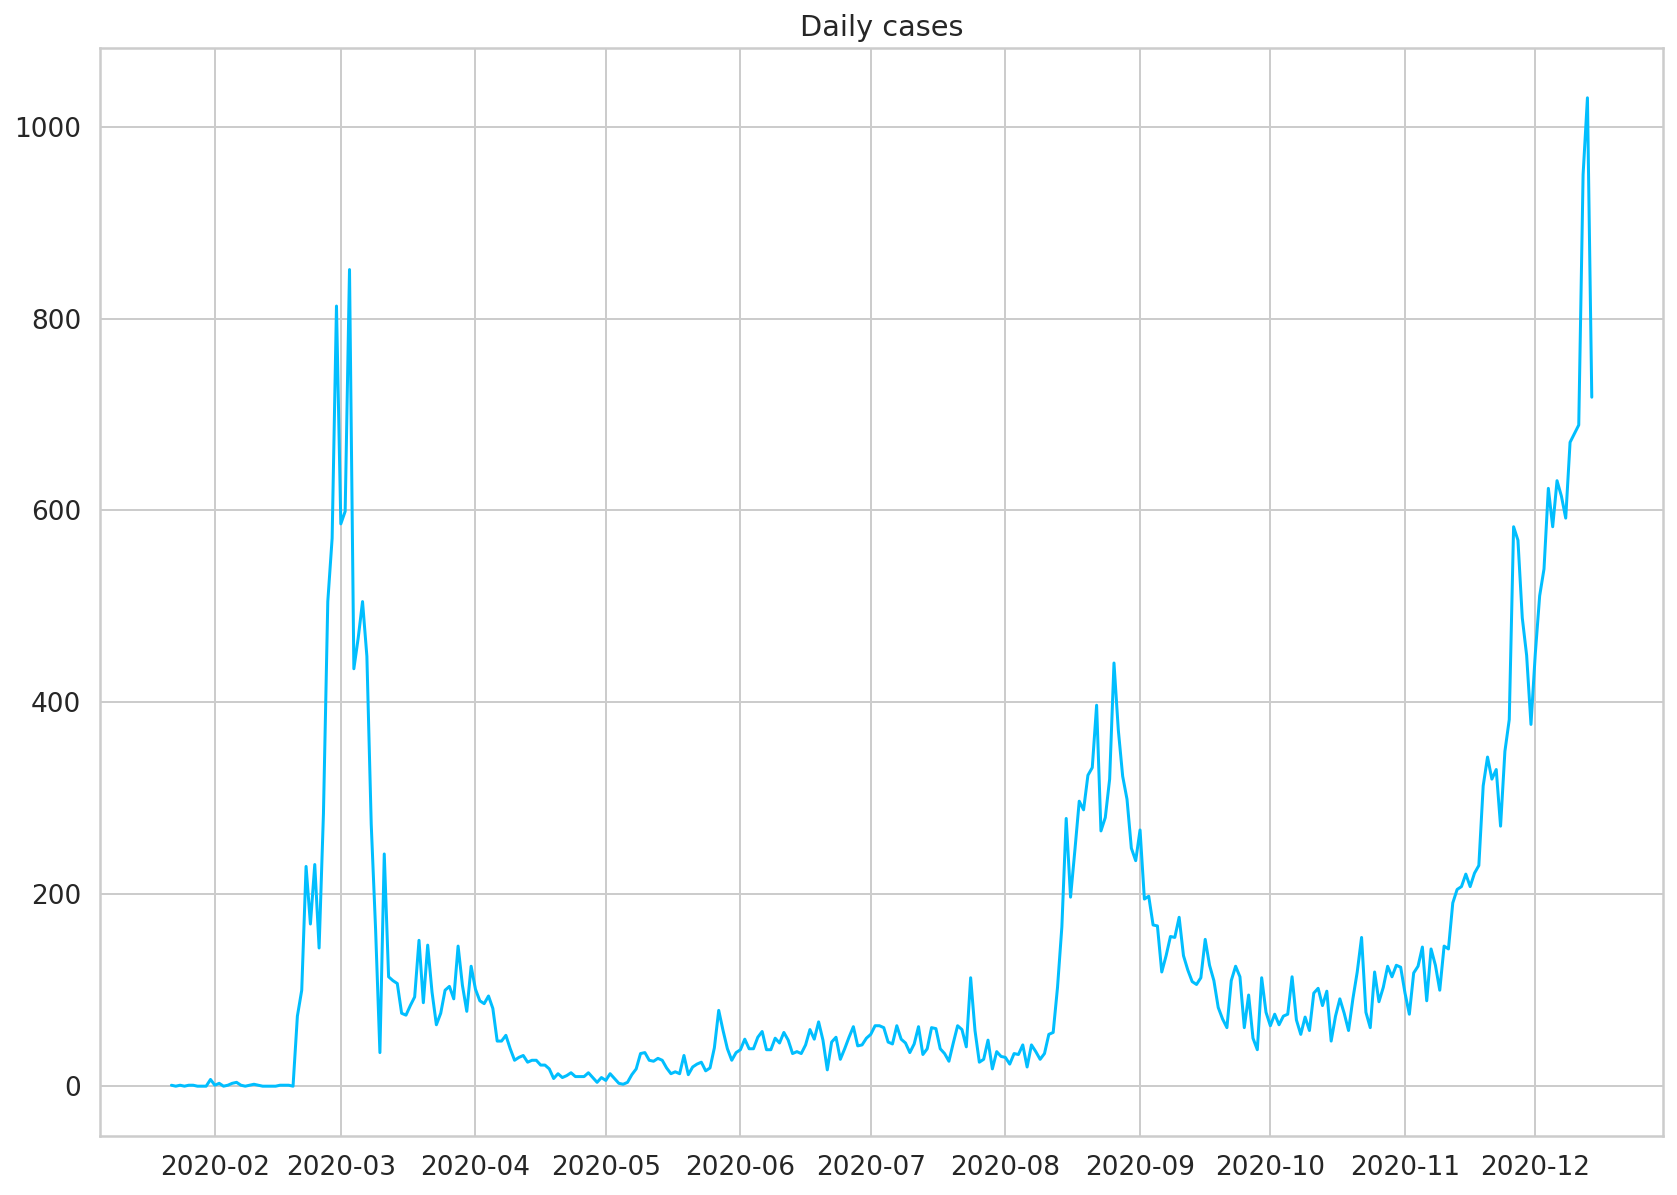

In [ ]:
plt.plot(daily_cases)
plt.title("Daily cases");

총 데이터는 328개가 있는 것을 확인할 수 있고 테스트를 위해 8:2의 비율로 나눠 학습을 진행해보겠습니다.

In [ ]:
daily_cases.shape

(328,)

In [ ]:
test_data_size = 66
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data.shape

(262,)

train_data와 test_data에 스케일링을 진행해줍니다.

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

LSTM 모델을 사용하기 위해 시퀀스 데이터 형성 함수를 정의했습니다.

RNN, GRU, LSTM과 같은 시퀀스 모델은 시퀀스 데이터가 필요하기 때문에 아래와 같은 시퀀스 데이터를 만들어주는 함수가 필요합니다.

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([257, 5, 1]),
 torch.Size([257, 1]),
 torch.Size([61, 5, 1]),
 torch.Size([61, 1]))

## 4.3 모델 정의

LSTM 모델을 생성해보겠습니다. `CovidPredictor` 클래스는 기본 변수와 layer를 초기화 해주는 생성자와 학습 초기화를 위한 `reset_hidden_state` 함수 그리고 `forword` 함수를 포함하고 있습니다.

In [ ]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.2
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 4.4 학습

4.3절에서 정의한 CovidPredictor 클래스와 아래 코드를 활용하여 학습을 진행합니다.


In [ ]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 110
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return model.eval(), train_hist, test_hist

In [ ]:
model = CovidPredictor(
    n_features=1,
    n_hidden=16,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, test_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RuntimeError: ignored

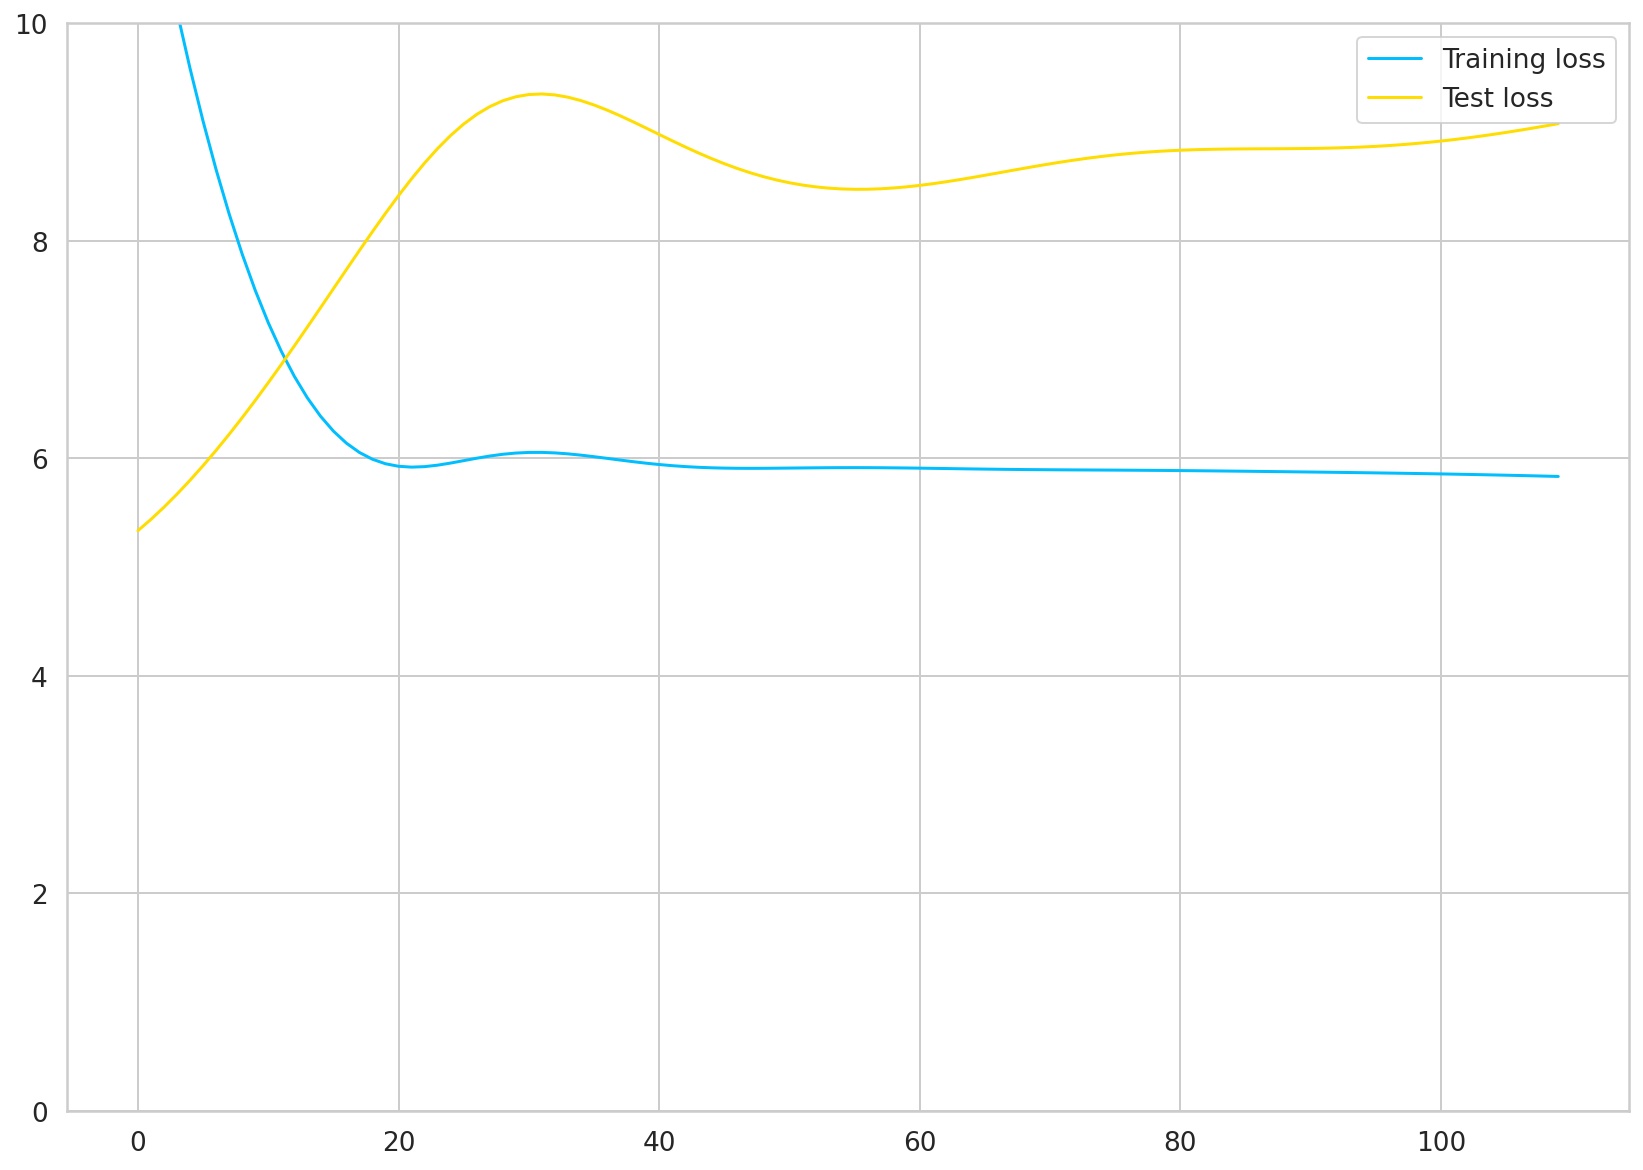

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend();

## 4.5 예측

### 4.5.1 미래 예측

In [ ]:
with torch.no_grad():
    preds = []
    for _ in range(len(X_train)):
        y_test_pred = model(torch.unsqueeze(X_train[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

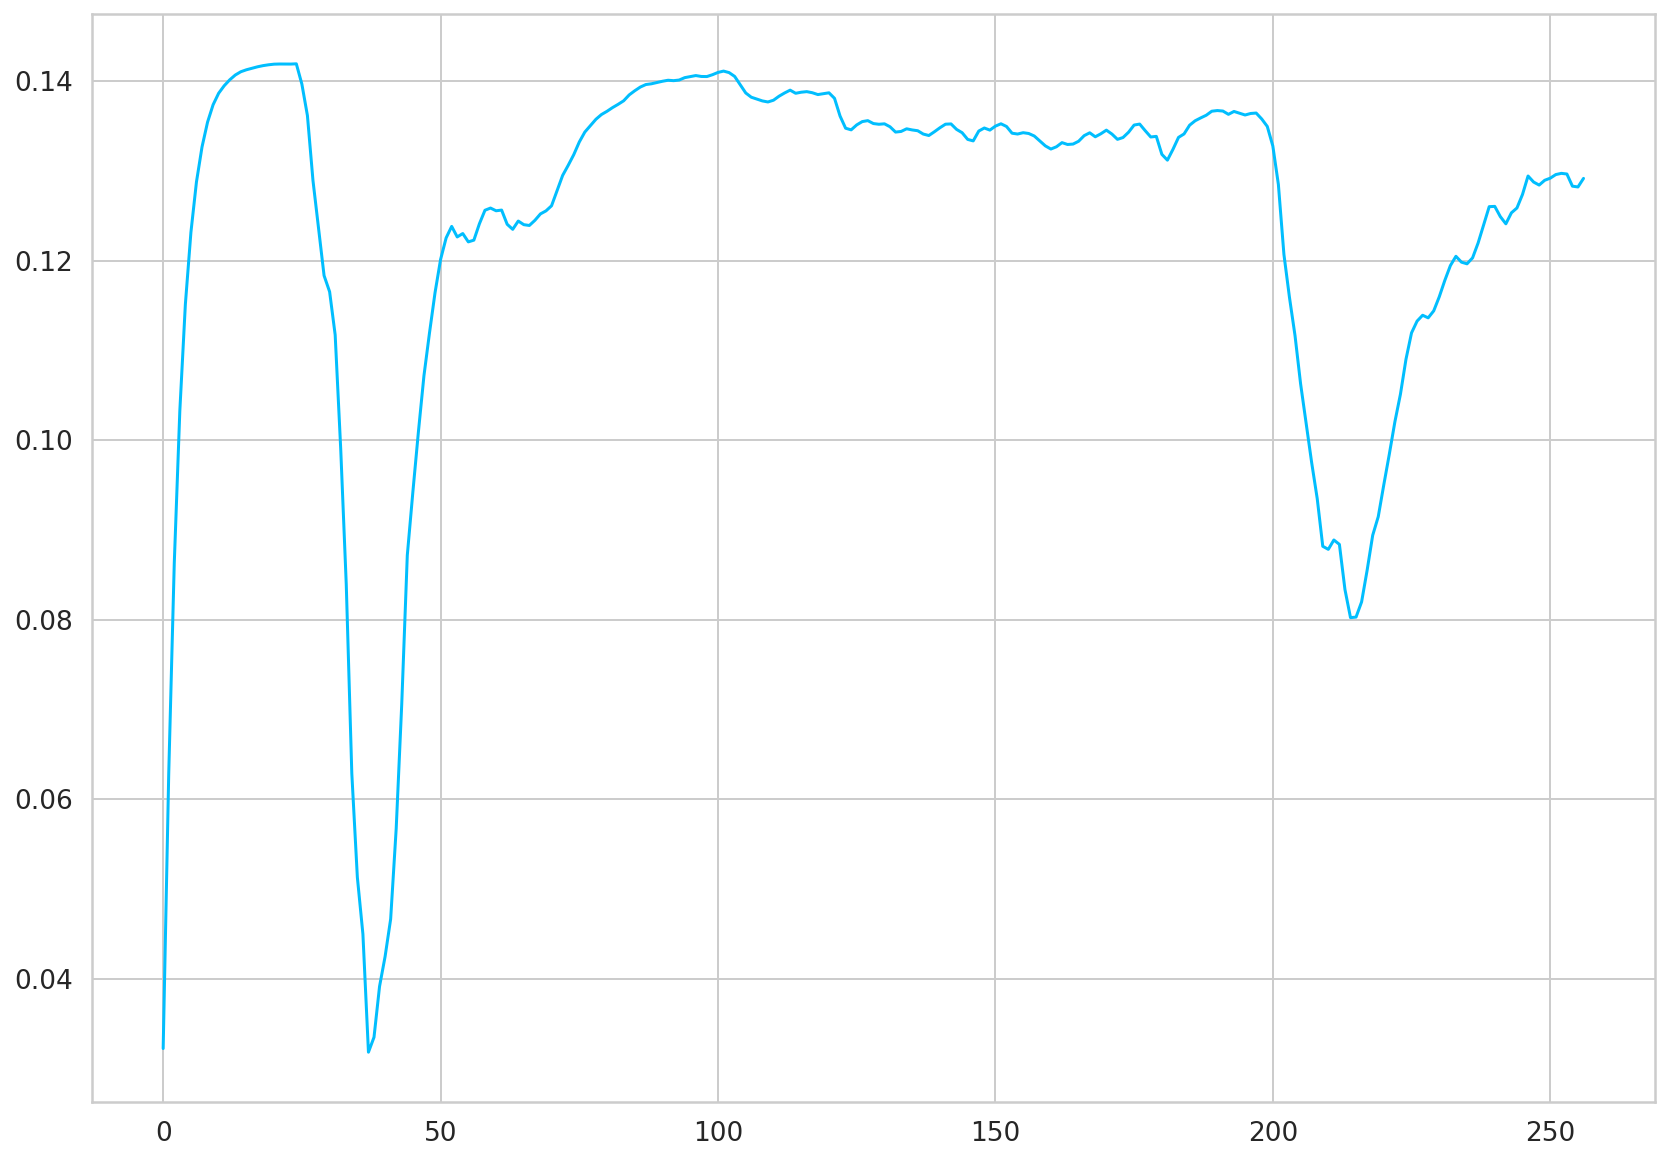

In [ ]:
plt.plot(preds)

In [ ]:
with torch.no_grad():
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(torch.unsqueeze(X_test[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

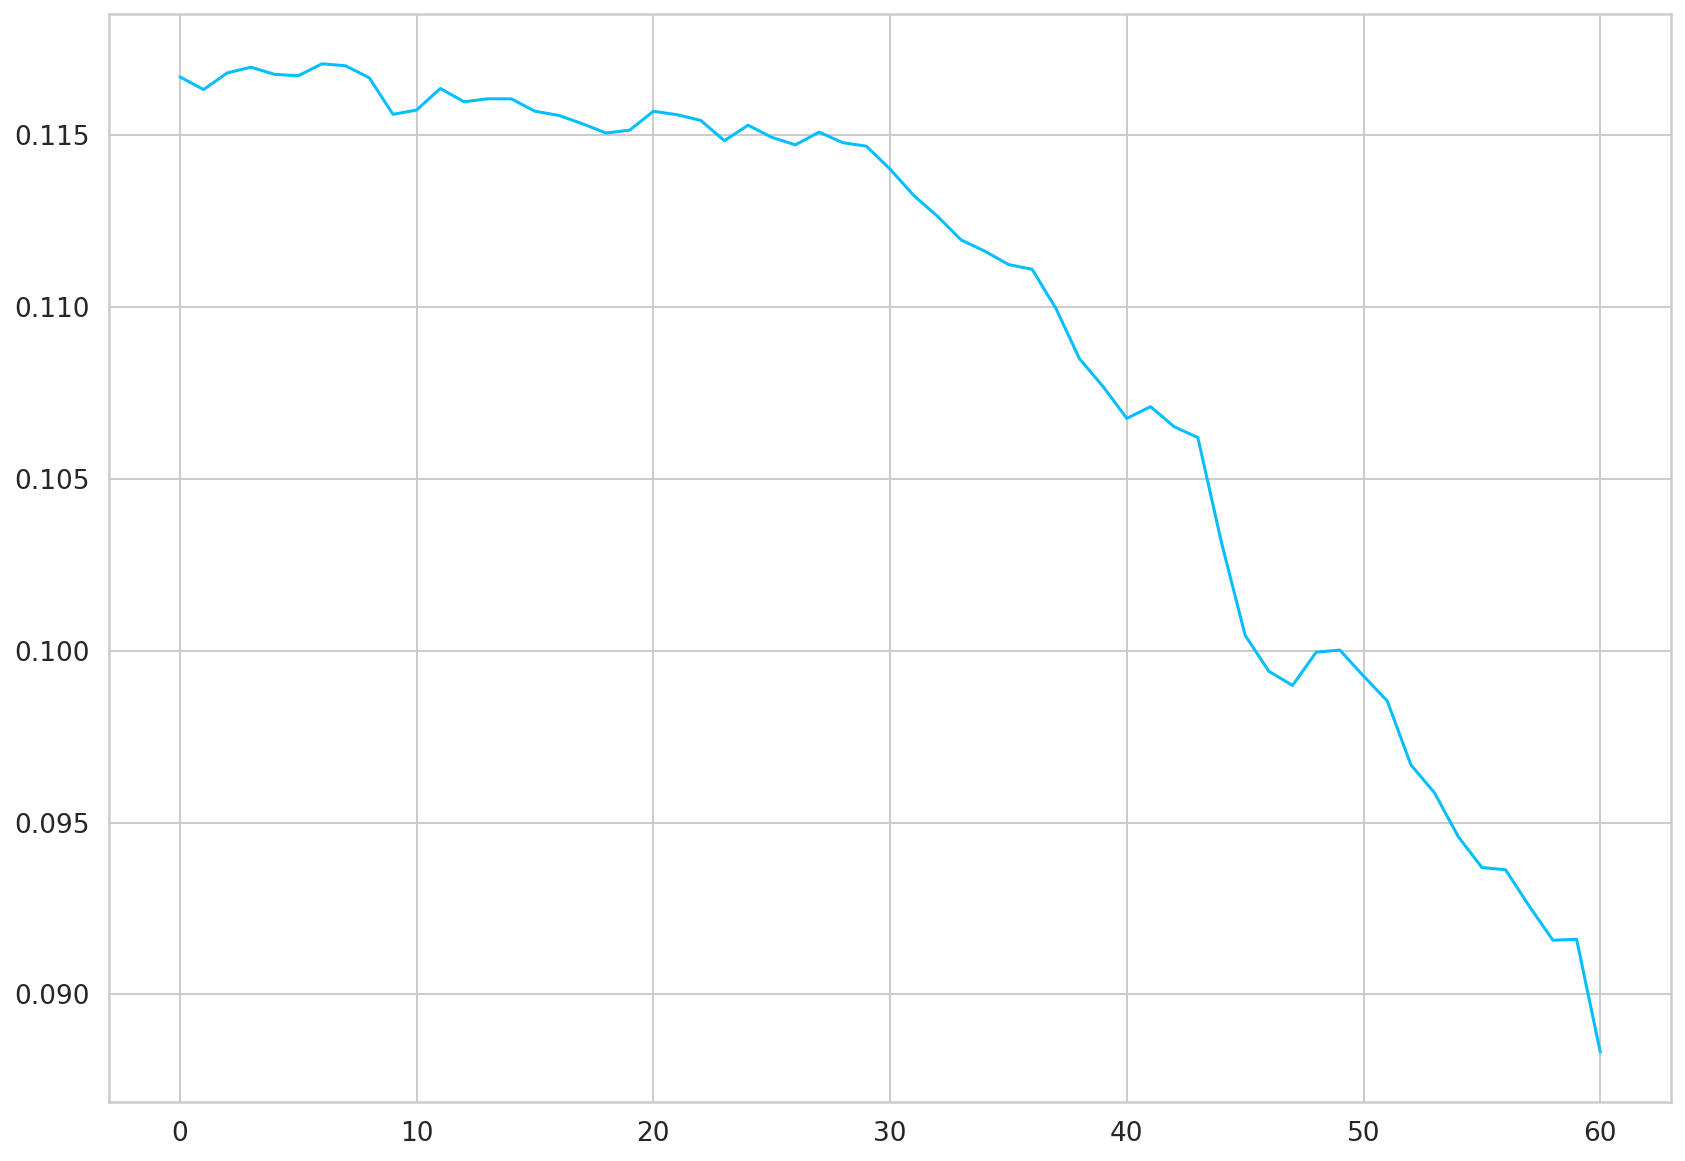

In [ ]:
plt.plot(preds)

In [ ]:
preds = np.array(preds)

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
    np.expand_dims(((preds - MIN) / (MAX - MIN)), axis=0)
).flatten()

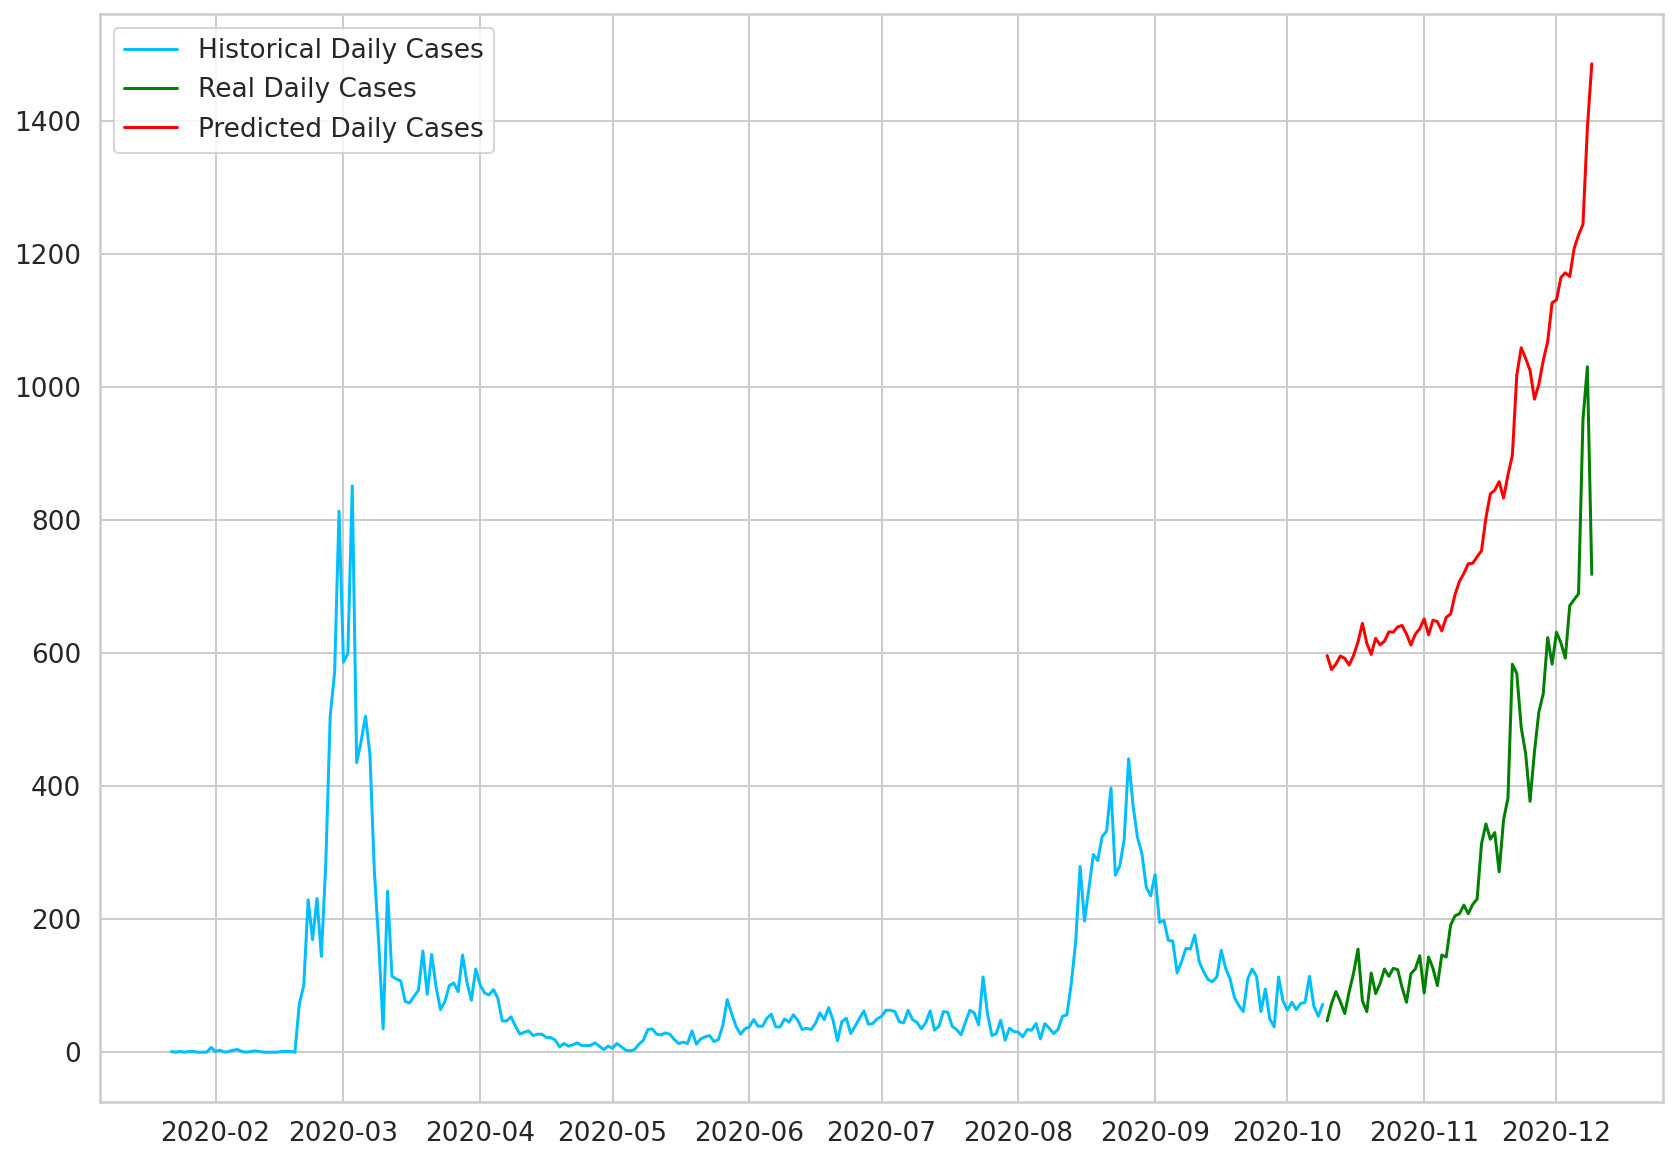

In [ ]:
plt.plot(
    daily_cases.index[:len(train_data)],
    scaler.inverse_transform(train_data).flatten(),
    label='Historical Daily Cases'
)
plt.plot(
    daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
    true_cases,
    label='Real Daily Cases',
    color='green'
)
plt.plot(
    daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
    predicted_cases,
    label='Predicted Daily Cases',
    color='red'
)
plt.legend();

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(328, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CovidPredictor(
    n_features=1,
    n_hidden=16,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, _ = train_model(model, X_all, y_all)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0 train loss: 5.966988563537598
Epoch 10 train loss: 5.872767448425293
Epoch 20 train loss: 5.779831886291504
Epoch 30 train loss: 5.677333354949951
Epoch 40 train loss: 5.553009986877441
Epoch 50 train loss: 5.395269393920898
Epoch 60 train loss: 5.195114612579346
Epoch 70 train loss: 5.020073413848877
Epoch 80 train loss: 5.0145111083984375
Epoch 90 train loss: 4.97806978225708
Epoch 100 train loss: 4.968137741088867


In [ ]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2020-12-14 00:00:00')

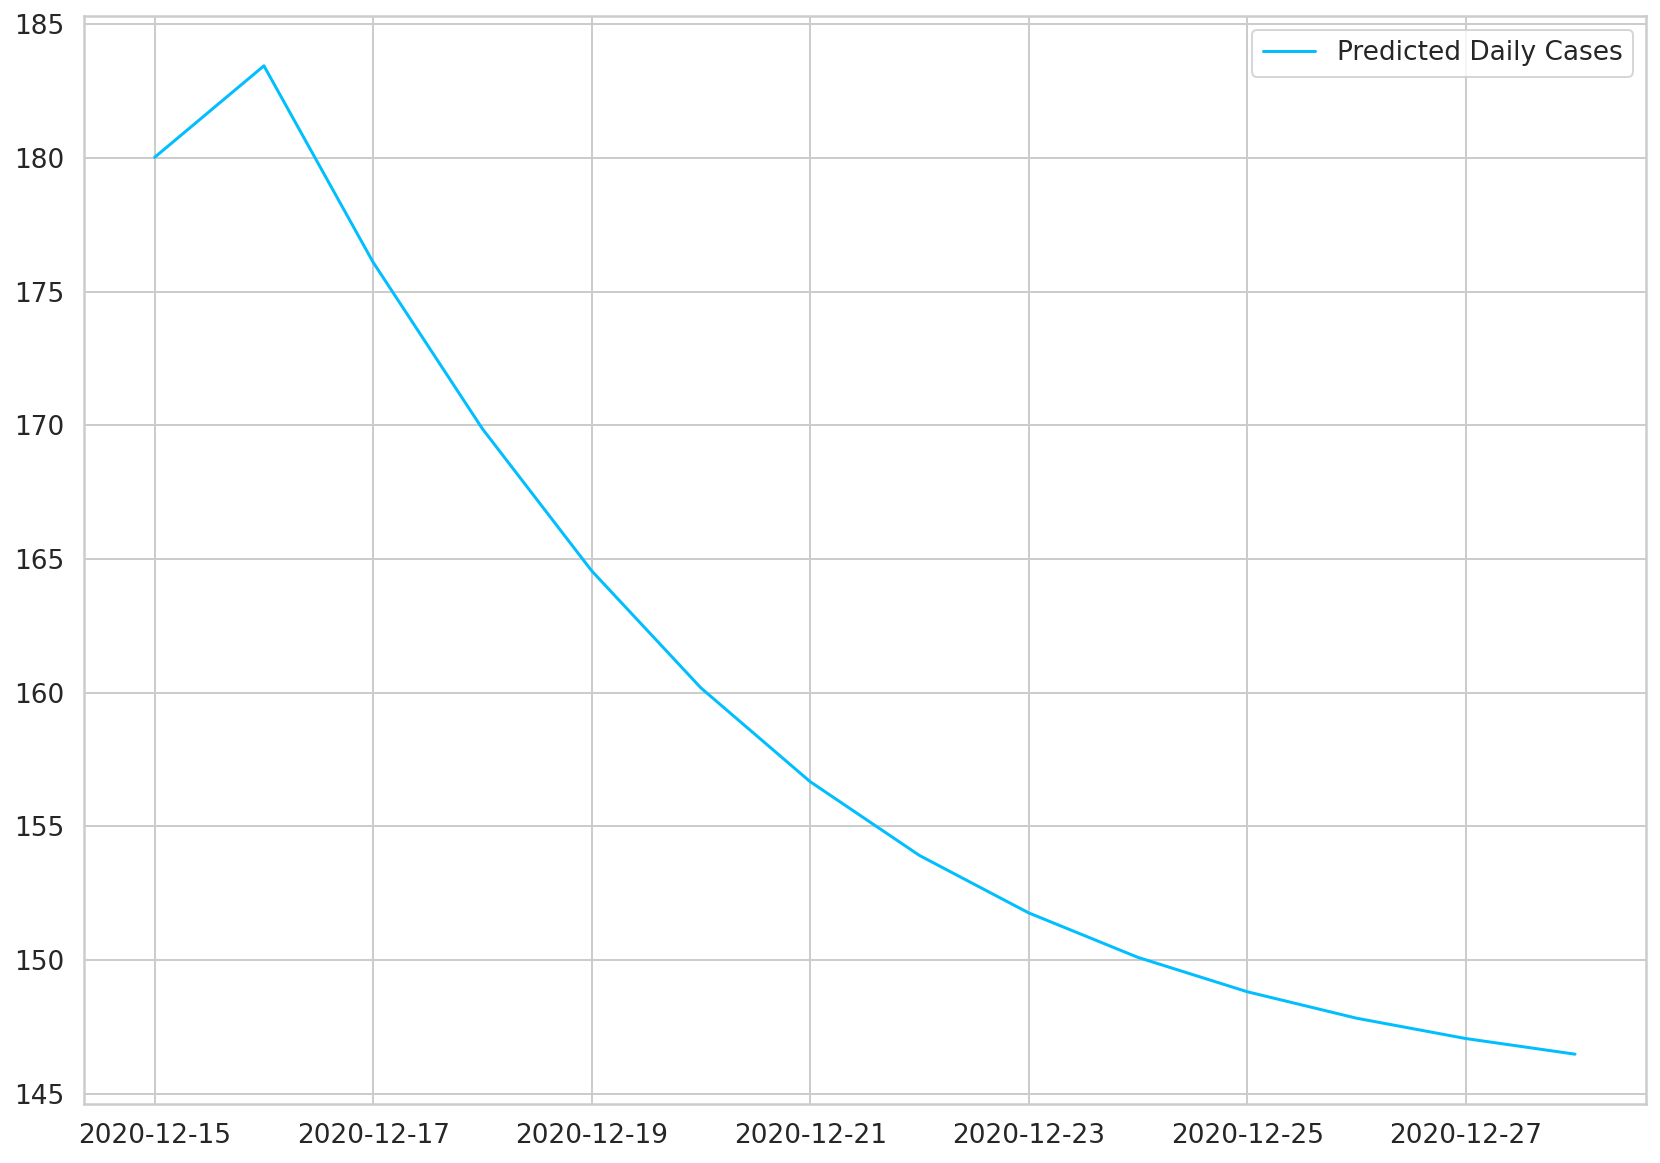

In [ ]:
predicted_index = pd.date_range(
    start=daily_cases.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    closed='right'
)
predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

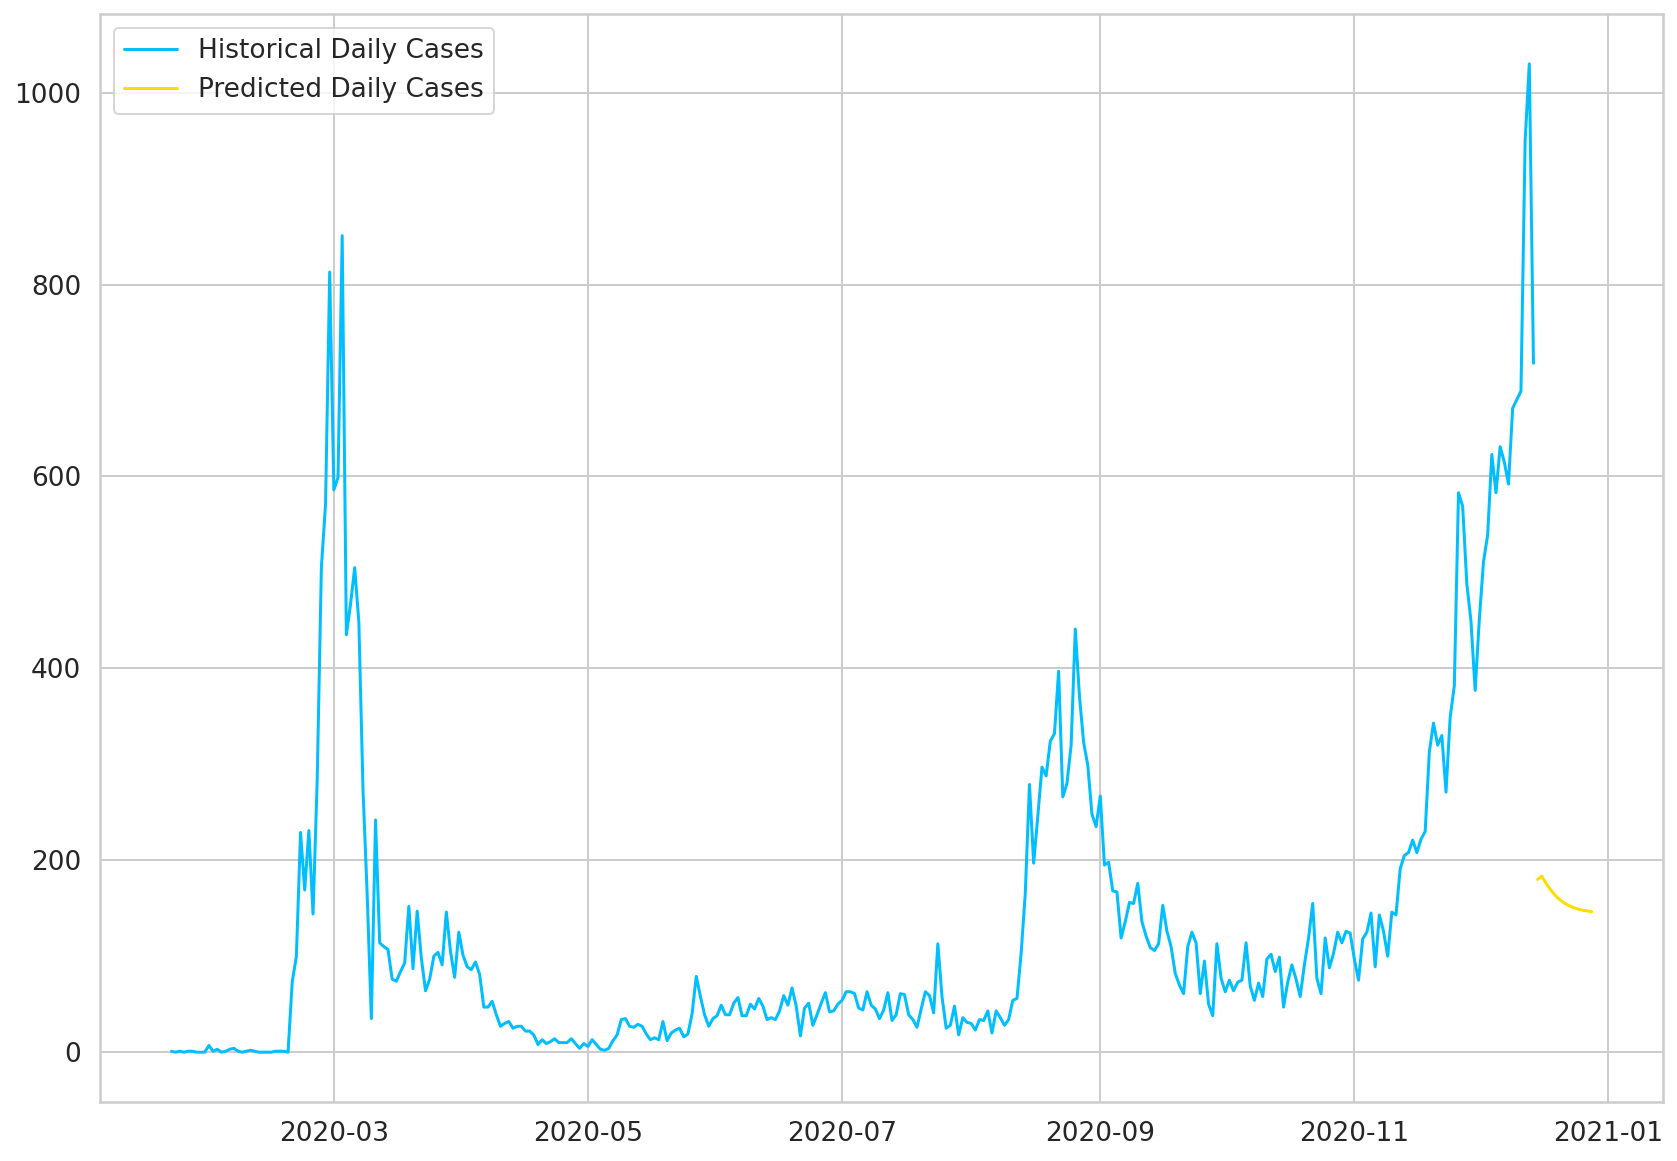

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();